<h1>Image Classifier</h1>

This project is based on the image classification using local binary pattern methodology.

There will be two folders consist of two data sets inside the images folder in the root directory.
   1. Labeled data
   2. Test data
   
Lets get started .....!

In [95]:
#<libraries>
from skimage import io
from skimage import data,exposure
from skimage import util
from skimage.util import random_noise
from skimage.transform import rescale,rotate
from skimage.feature import local_binary_pattern
from skimage.filters import gaussian
from skimage.color import rgb2gray,grey2rgb
import numpy as np
from numpy import asarray
import cv2
import matplotlib.pyplot as plt
import sys,glob,os,warnings
%matplotlib inline

**Data augmentation to create multiple lbp texture identification** 

This process would increase the test data set. Highend pattern recognition models such as Deeplearning model
use this functionality to increase the data to increase accuracy. 

In [107]:
def image_augmentation(image): 
   
    """
    This function takes a image as a input an  create set of images from the 
    same image by using different ways of processing methods.
    
    Args:
        param1 (image): Image need to be processed.

    Returns:
        Set of images of processed images as follows.
        array < -- |image rescale to 25%                            |                          
                   |image rescale to 50%                            |
                   |image with random noise                         |
                   |invert version of image                         |
                   |image rotated 45                                |
                   |image rotated 90                                |
                   |elavated contrast image                         |
                   |ajusted gama gain parameters are between 0 and 1|
                   |sigmoid                                         |
                   |verticle flip                                   |
    """
    
    augmented_images = []  # storting  augmented pictures
    
    # rescale image to 25% 
    image_rescale_25 = rescale(image, 1.0 / 4.0)
    augmented_images.append(image_rescale_25)
    
    # rescale image to 50% 
    image_rescale_50 = rescale(image, 1.0 / 2.0)
    augmented_images.append(image_rescale_50)

    # image with noise
    image_with_random_noise = random_noise(image)
    augmented_images.append(image_with_random_noise)

    #invert image
    image_inverted = util.invert(image)
    augmented_images.append(image_inverted)

    
    # image rotation 45
    image_rotation_45= rotate(image, 45)
    augmented_images.append(image_rotation_45)
    
    # image rotation 90
    image_rotation_90= rotate(image, 90)
    augmented_images.append(image_rotation_45)

    # contrast
    image_min, image_max = np.percentile(image, (0.2, 99.8))
    contrast = exposure.rescale_intensity(image, in_range=(image_min, image_max))
    augmented_images.append(contrast)

    # gamma and gain parameters are between 0 and 1
    adjusted_gamma_image = exposure.adjust_gamma(image, gamma=0.4, gain=0.9)
    augmented_images.append(adjusted_gamma_image)

    # sigmoid 
    image_sigmoid = exposure.adjust_sigmoid(image)
    augmented_images.append(image_sigmoid)

    # Vertical flip   : 180 rotation
    vertical_flip = original_image[::-1, :]
    augmented_images.append(vertical_flip)

    return augmented_images


In [110]:
#Kullback–Leibler divergence (also called relative entropy) is a measure of how one probability distribution is different from a second, reference probability distribution
def kullback_leibler_divergence(p_samples, q_samples):
    """
    This function would calculate divergence from two vectors from a  samples from distributions
    Args:
        param1 (p) : vector1  : list
        param2 (q) : vector2  : list
        
    Retrun : 
        Divergence 
    """
    # convert to numpy array
    p = np.asarray(p_samples)
    q = np.asarray(q_samples)
    filt = np.logical_and(p != 0, q != 0) # both p and q needs to be true return true 
    return np.sum(p[filt] * np.log2(p[filt] / q[filt]))

In [147]:
def getClosestClass(labelImages, testImages):
    """
    This function takes an image as an input an  create set of images from the 
    same image by using different ways of processing methods.
    
    Args:
        param1 (labelImages): labeled images
        param2 (testImages) : test images 

    Returns:
        closest class name 
        max_distribution
    """
    imglen = len(testImages)
    images_np = np.array(testImages) # numpy array to make it easier
    max_distribution  = 17
    closest_label_name = None
    for i in range(0,imglen-1):
        lbp = local_binary_pattern(images_np[i,], point_count, radius, method)
        n_bins = int(lbp.max() + 1)
        hist, _ = np.histogram(lbp, density=True, bins=n_bins, range=(0, n_bins))
        for labelname, image in labelImages.items():
            ref_hist, _ = np.histogram(image, density=True, bins=n_bins,range=(0, n_bins))  
            loss = kullback_leibler_divergence(hist, ref_hist)
            if loss < max_distribution:
                max_distribution = loss # identify the maximum loss
                closest_label_name = labelname # identify the maximum name
    return closest_label_name,max_distribution


In [170]:
def loadLabeldata():
    """
    This function load all the label data and return the two lists. 
    
    Returns:
        1. label image
        2. label lbd
    """
    lbp_ref_dictionary= {}      # store reference image list [ 'imageName' , np.array(image) ]      
    images_ref_dictionary = {}  # store reference image list [ 'imageName' , np.array(ldb <- image ) ]
    
    for filename in glob.glob('images/labelData/*'): 

        # Getting path
        filename          = os.path.basename(filename)  # getting the file name
        fileurl           = 'images/labelData/'+filename  # recreate read url due to incorrect path return from glob   ex :"images / labelData \ image_1.png"          
        image_np          = np.array(io.imread(fileurl, as_gray=True) )

        # Storing ldp for faster search 
        lbp               = local_binary_pattern(image_np, point_count, radius, method)
        fileName_absolute = os.path.basename(filename)
        fileNamesplit     = fileName_absolute.split(".")

        # storing data 
        images_ref_dictionary[fileNamesplit[0]] = image_np 
        lbp_ref_dictionary[fileNamesplit[0]]    = lbp
    
    return lbp_ref_dictionary,images_ref_dictionary

In [157]:
# draw histogram
def hist(ax, lbp):
    n_bins = int(lbp.max() + 1)
    return ax.hist(lbp.ravel(), density=True, bins=n_bins, range=(0, n_bins),facecolor='0.5')

In [158]:
# Plot labels and 
def plotgraphs(original_image,label_image,point_count, radius, method):
 
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2,figsize=(15,15))

    ax1.imshow(original_image)
    ax1.axis('off')
    hist(ax2,local_binary_pattern(original_image, point_count, radius, method))
    ax2.set_ylabel('Percentage')
    ax2.set_xlabel('intensity groups')

    ax3.imshow(images_ref_dictionary[closest_class])
    ax3.axis('off')
    hist(ax4,local_binary_pattern(images_ref_dictionary[closest_class], point_count, radius, method))
    ax4.set_ylabel('Percentage')
    ax4.set_xlabel('intensity groups')


# Run the classifier #


In [171]:
# Get the testing file 
# You can use any file from the testData folder

original_image   = io.imread('images/testData/longleaf.jpeg',as_gray=True) # load the data in gray scale

**Radius 1**<br> 
**Points 8**

In [ ]:
# settings for LBP
radius = 1
point_count = 8 * radius
method = 'uniform'

In [165]:
# Make more image sernarios with input image
augmented_images_stack = image_augmentation(original_image)

**Reading label data**

In [166]:
# Reading data            
lbp_ref_dictionary,images_ref_dictionary  = loadLabeldata()      

print('Data loaded')

Data loaded


In [167]:
# Find the closest class label 
closest_label_name,max_distribution = getClosestClass(lbp_ref_dictionary,augmented_images_stack)
print('closest class    : ',closest_label_name)
print('max_distribution : ',max_distribution)

closest class    :  napier_grass_2
max_distribution :  0.07321073888788454


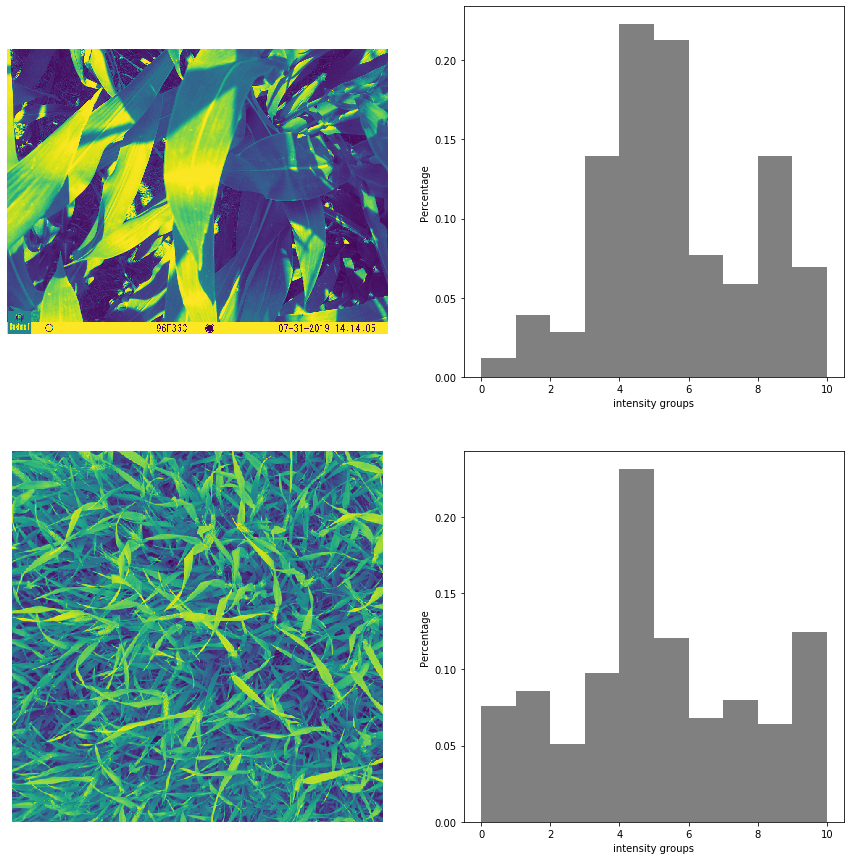

In [159]:
# plot distribution
plotgraphs(original_image,closest_label_name,point_count, radius, method)

**Radius 2**<br> 
**Points 16**

In [160]:
# settings for LBP
radius = 2
point_count = 8 * radius
method = 'uniform'

# Make more image sernarios with input image
augmented_images_stack = image_augmentation(original_image)

# Reading data            
lbp_ref_dictionary,images_ref_dictionary  = loadLabeldata()      

print('Data loaded')

# Find the closest class label 
closest_label_name,max_distribution = getClosestClass(lbp_ref_dictionary,augmented_images_stack)
print('closest class    : ',closest_label_name)
print('max_distribution : ',max_distribution)

# plot distribution
plotgraphs(original_image,closest_label_name,point_count, radius, method)

**Radius 3**<br> 
**Points 24**

Data loaded
closest class    :  sand_2
max_distribution :  0.09669837348769127


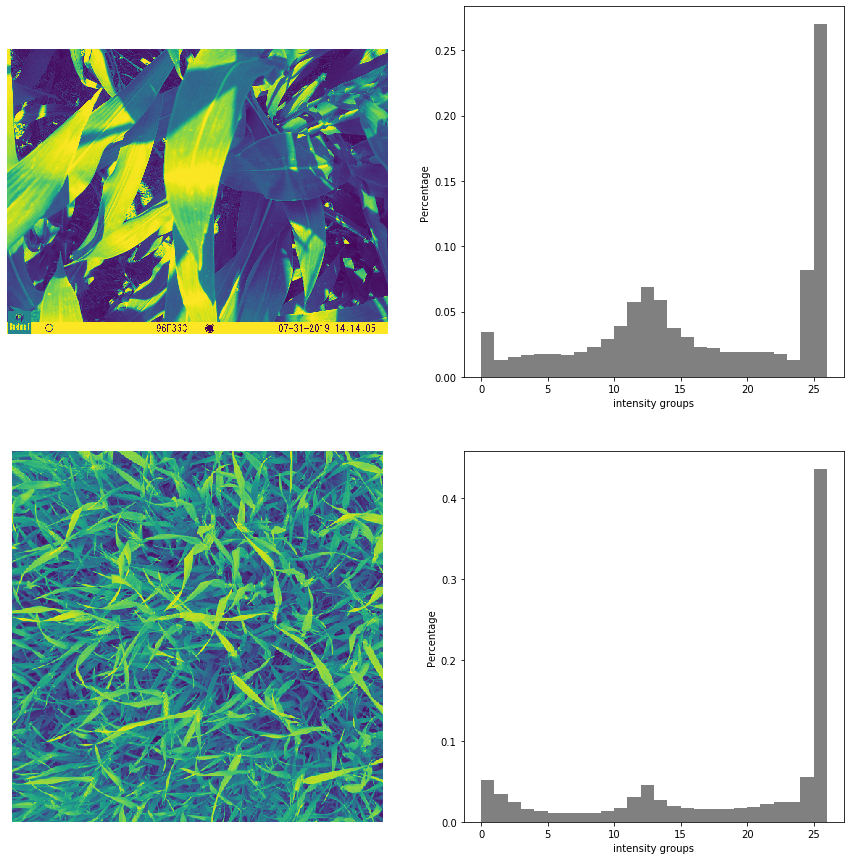

In [168]:
# settings for LBP
radius = 3
point_count = 8 * radius
method = 'uniform'

# Make more image sernarios with input image
augmented_images_stack = image_augmentation(original_image)

# Reading data            
lbp_ref_dictionary,images_ref_dictionary  = loadLabeldata()      

print('Data loaded')

# Find the closest class label 
closest_label_name,max_distribution = getClosestClass(lbp_ref_dictionary,augmented_images_stack)
print('closest class    : ',closest_label_name)
print('max_distribution : ',max_distribution)

# plot distribution
plotgraphs(original_image,closest_label_name,point_count, radius, method)